# LDA for Enron Emails

Installing dependencies

In [6]:
import pandas as pd
import nltk
import re
import warnings
from tqdm import tqdm

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# enron_emails_df=pd.read_csv('./data/filter_50krows.csv')
enron_emails_df=pd.read_csv('../data/finalv1_data.csv')
enron_emails_df.head()

,From,To,Subject,X-cc,X-bcc,Content,Job_Title,Total_Sentence_Word_Count,From_Names,To_Names,Cleaned_Content,BoW,DateTime
0,phillip.allen@enron.com,john.lavorato@enron.com,Re:,X-bcc:,"X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...",Traveling to have a business meeting takes the...,Unknown,139,phillip allen,john lavorato,traveling business meeting takes fun trip espe...,"['traveling', 'business', 'meeting', 'takes', ...",4 May 2001
1,phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,X-bcc:,X-Folder: \Phillip_Allen_Dec2000\Notes Folders...,"Randy,\n\n Can you send me a schedule of the s...",Unknown,33,phillip allen,randall gay,randy send schedule salary level everyone sche...,"['randy', 'send', 'schedule', 'salary', 'level...",23 Oct 2000
2,phillip.allen@enron.com,"david.l.johnson@enron.com, john.shafer@enron.com",Mime-Version: 1.0,X-bcc:,X-Folder: \Phillip_Allen_Dec2000\Notes Folders...,Please cc the following distribution list with...,Unknown,22,phillip allen,"david l johnson, john shafer",following distribution updates phillip allen p...,"['following', 'distribution', 'updates', 'phil...",22 Aug 2000
3,phillip.allen@enron.com,mark.scott@enron.com,Re: High Speed Internet Access,X-bcc:,X-Folder: \Phillip_Allen_Dec2000\Notes Folders...,1. login: pallen pw: ke9davis\n\n I don't thi...,Unknown,31,phillip allen,mark scott,1 login pallen pw ke9davis dont think required...,"['1', 'login', 'pallen', 'pw', 'ke9davis', 'do...",17 Oct 2000
4,phillip.allen@enron.com,zimam@enron.com,FW: fixed forward or other Collar floor gas pr...,X-bcc:,X-Folder: \Phillip_Allen_Dec2000\Notes Folders...,---------------------- Forwarded by Phillip K ...,Unknown,300,phillip allen,zimam,phillip k allenhouect 10162000 0142 buckner bu...,"['phillip', 'k', 'allenhouect', '10162000', '0...",16 Oct 2000


In [4]:
enron_emails_df["BoW"].head()

0    ['traveling', 'business', 'meeting', 'takes', ...
1    ['randy', 'send', 'schedule', 'salary', 'level...
2    ['following', 'distribution', 'updates', 'phil...
3    ['1', 'login', 'pallen', 'pw', 'ke9davis', 'do...
4    ['phillip', 'k', 'allenhouect', '10162000', '0...
Name: BoW, dtype: object

In [ ]:
import ast

# Convert the "BoW" column into an array of arrays
enron_docs = []
for row in enron_emails_df["BoW"]:
    enron_docs.append(ast.literal_eval(row))

# print(enron_docs[:2])

In [7]:
import gensim
enron_dictionary = gensim.corpora.Dictionary(enron_docs)
enron_vecs = [enron_dictionary.doc2bow(doc) for doc in enron_docs]

## Find optimal number of Topics (K)

In [8]:
# Can take a long time to run. In this case we are going to k_max=10.
import datetime
from tqdm import tqdm  # Import tqdm for progress bar
from gensim.models import CoherenceModel

print(datetime.datetime.now())

model_list = []
coherence_values = []
model_topics = []

# Use tqdm to wrap the range for progress tracking
for num_topics in tqdm(range(2, 14, 2), desc="Training LDA Models"):
    enron_lda_x = gensim.models.ldamodel.LdaModel(corpus=enron_vecs, id2word=enron_dictionary, num_topics=num_topics)
    coherencemodel = CoherenceModel(model=enron_lda_x, texts=enron_docs, dictionary=enron_dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(enron_lda_x)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

print(datetime.datetime.now())

2025-03-31 18:34:16.312855


Training LDA Models:  17%|█▋        | 1/6 [1:41:48<8:29:02, 6108.42s/it]

#Topics: 2 Score: 0.3927301908237424


Training LDA Models:  33%|███▎      | 2/6 [2:01:15<3:33:27, 3201.88s/it]

#Topics: 4 Score: 0.4683681411621863


Training LDA Models:  50%|█████     | 3/6 [2:25:58<2:00:51, 2417.04s/it]

#Topics: 6 Score: 0.5056877600180215


Training LDA Models:  67%|██████▋   | 4/6 [3:00:15<1:15:49, 2274.59s/it]

#Topics: 8 Score: 0.5006085177848371


Training LDA Models:  83%|████████▎ | 5/6 [3:19:27<31:10, 1870.11s/it]  

#Topics: 10 Score: 0.49032639580444914


Training LDA Models: 100%|██████████| 6/6 [3:46:21<00:00, 2263.63s/it]

#Topics: 12 Score: 0.5865479065687235
2025-03-31 22:20:38.170205


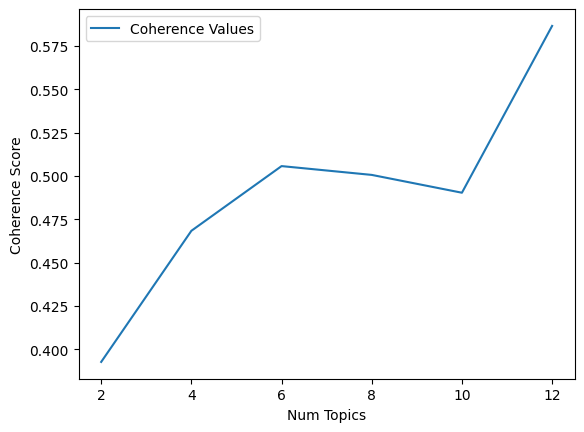

In [9]:
import matplotlib.pyplot as plt

# Use the same range as the loop that generated coherence_values
start = 2
limit = 14
step = 2
x = range(start, limit, step)  # This will match the length of coherence_values

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(["Coherence Values"], loc="best")
plt.show()

## Build the LDA Model

In [10]:
# Number of passes (iterations over the corpus)
num_passes = 10

# Initialize the LDA model
enron_lda = gensim.models.ldamodel.LdaModel(
    corpus=enron_vecs,
    id2word=enron_dictionary,
    num_topics=12,
    passes=1,  # Set passes to 1 for manual looping
    update_every=1,
    per_word_topics=True
)

# Use tqdm to track progress
for i in tqdm(range(num_passes), desc="Training LDA Model"):
    enron_lda.update(enron_vecs)  # Update the model with the corpus

Training LDA Model: 100%|██████████| 10/10 [11:25:11<00:00, 4111.15s/it]  


In [11]:
topics = enron_lda.show_topics(12, 5)

for i in range(0, 12 ):
    print(topics[i])

(0, '0.038*"final" + 0.035*"dbcaps97data" + 0.031*"schedule" + 0.027*"hour" + 0.026*"000"')
(1, '0.024*"sara" + 0.021*"fax" + 0.016*"agreement" + 0.016*"houston" + 0.016*"phone"')
(2, '0.020*"deal" + 0.020*"gas" + 0.012*"price" + 0.012*"deals" + 0.007*"day"')
(3, '0.020*"kate" + 0.017*"john" + 0.015*"david" + 0.015*"kay" + 0.008*"chris"')
(4, '0.022*"richard" + 0.018*"jeff" + 0.017*"james" + 0.013*"steve" + 0.011*"steven"')
(5, '0.065*"2001" + 0.063*"message" + 0.061*"original" + 0.019*"october" + 0.018*"monday"')
(6, '0.032*"error" + 0.032*"message" + 0.031*"intended" + 0.021*"information" + 0.019*"confidential"')
(7, '0.022*"power" + 0.020*"said" + 0.015*"energy" + 0.010*"market" + 0.010*"california"')
(8, '0.017*"get" + 0.015*"know" + 0.011*"like" + 0.011*"think" + 0.010*"one"')
(9, '0.009*"agreement" + 0.008*"information" + 0.008*"need" + 0.007*"database" + 0.006*"questions"')
(10, '0.036*"20" + 0.009*"business" + 0.009*"new" + 0.009*"financial" + 0.009*"enrons"')
(11, '0.021*"meet

In [12]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [13]:
# Generate the visuals
visual= gensimvis.prepare(enron_lda, enron_vecs, enron_dictionary)

In [14]:
#Save the output to the html file
pyLDAvis.save_html(visual, "enron_topic_viz.html")

## Perplexity & Coherence Scores

In [15]:
# Compute Perplexity
perplex= enron_lda.log_perplexity(enron_vecs, total_docs=None) #For LDAModel
  # a measure of how good the model is. lower the better.
print('\nPerplexity for LDAModel: ', perplex)



Perplexity for LDAModel:  -11.603603439399386


In [16]:
# Compute Coherence Score
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=enron_lda, texts=enron_docs, dictionary=enron_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDAModel: ', coherence_lda)


Coherence Score LDAModel:  0.6422797787617941


## Most Dominant Topic

In [17]:
#Find most dominant topic

import numpy as np

def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    rows = []
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                rows.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break
    sent_topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('Text')], axis=1)
    return sent_topics_df

# I choose model_list[2] where the number of topics is 6
df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[3], corpus=enron_vecs, data=enron_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5,0.8738,"one, time, new, us, 000, like, work, get, make...","[traveling, business, meeting, takes, fun, tri..."
1,1,5,0.3430,"one, time, new, us, 000, like, work, get, make...","[randy, send, schedule, salary, level, everyon..."
2,2,6,0.5743,"message, original, 2001, know, meeting, monday...","[following, distribution, updates, phillip, al..."
3,3,7,0.3252,"john, david, sara, kate, paul, l, w, taylorhou...","[1, login, pallen, pw, ke9davis, dont, think, ..."
4,4,1,0.4639,"power, energy, said, market, gas, financial, n...","[phillip, k, allenhouect, 10162000, 0142, buck..."
5,5,0,0.3066,"database, information, agreement, dbcaps97data...","[mr, buckner, delivered, gas, behind, san, die..."
6,6,5,0.8567,"one, time, new, us, 000, like, work, get, make...","[lucy, rentrolls, open, save, rentroll, folder..."
7,7,2,0.5400,"deal, deals, know, need, 1, gas, price, let, 2...","[phillip, k, allenhouect, 10092000, 0216, rich..."
8,8,2,0.5416,"deal, deals, know, need, 1, gas, price, let, 2...","[phillip, k, allenhouect, 10092000, 0200, rich..."
9,9,2,0.3984,"deal, deals, know, need, 1, gas, price, let, 2...","[dave, names, west, desk, members, category, o..."


In [18]:
#Save a model to disk, or reload a pre-trained model
enron_lda_sav=model_list[3] #Or you can save the second best model, model_list[8]

enron_lda_sav.save("model_8Topics")

lda_disk=gensim.models.ldamodel.LdaModel.load("model_8Topics")